In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

In [3]:
# Coca-Cola (KO) vs PepsiCo (PEP)
tickers = ['KO', 'PEP']
start_date = "2020-01-01"
end_date = "2024-12-31"

data = yf.download(tickers, start=start_date, end=end_date)['Close']
data = data.dropna()
data.head()

/tmp/ipython-input-3-1591428710.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed


Ticker,KO,PEP
Date,,
2020-01-02,46.419701,115.337723
2020-01-03,46.166454,115.176376
2020-01-06,46.149578,115.617958
2020-01-07,45.795029,113.800674
2020-01-08,45.879440,114.386635


In [4]:
X = data['KO']
Y = data['PEP']

# Step 1: Estimate hedge ratio via OLS
X_const = add_constant(X)
model = OLS(Y, X_const).fit()
hedge_ratio = model.params['KO']
spread = Y - hedge_ratio * X

# Step 2: ADF test on residual spread
adf_stat, pvalue, *_ = adfuller(spread)
print(f"ADF Statistic: {adf_stat:.4f}, p-value: {pvalue:.4f}")


ADF Statistic: -2.1279, p-value: 0.2334


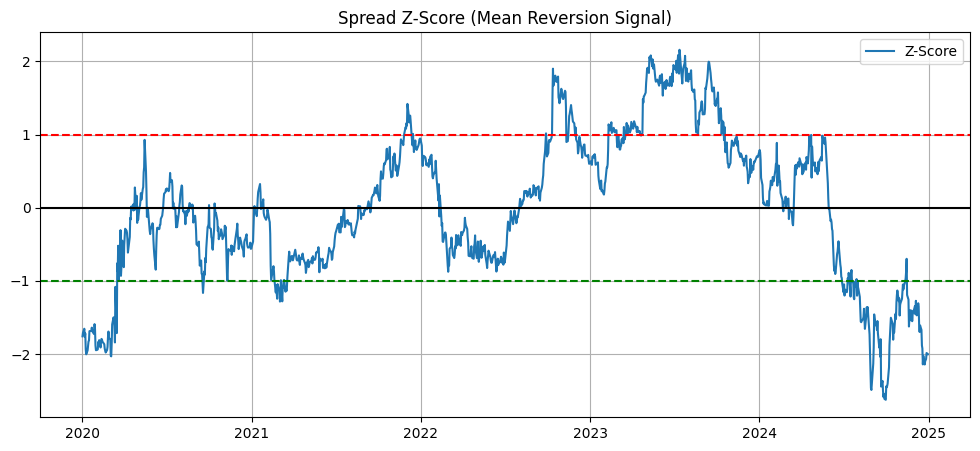

In [5]:
spread_mean = spread.mean()
spread_std = spread.std()
zscore = (spread - spread_mean) / spread_std

plt.figure(figsize=(12, 5))
plt.plot(zscore, label='Z-Score')
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.legend()
plt.title('Spread Z-Score (Mean Reversion Signal)')
plt.grid(True)
plt.show()


In [6]:
# Entry: Z > 1 → short spread, Z < -1 → long spread
# Exit: Z in (-0.5, 0.5)
positions = pd.DataFrame(index=zscore.index)
positions['long'] = zscore < -1
positions['short'] = zscore > 1
positions['exit'] = (zscore.abs() < 0.5)

# Position logic
positions['spread_pos'] = 0
positions.loc[positions['long'], 'spread_pos'] = 1
positions.loc[positions['short'], 'spread_pos'] = -1
positions.loc[positions['exit'], 'spread_pos'] = 0
positions['spread_pos'] = positions['spread_pos'].ffill().fillna(0)


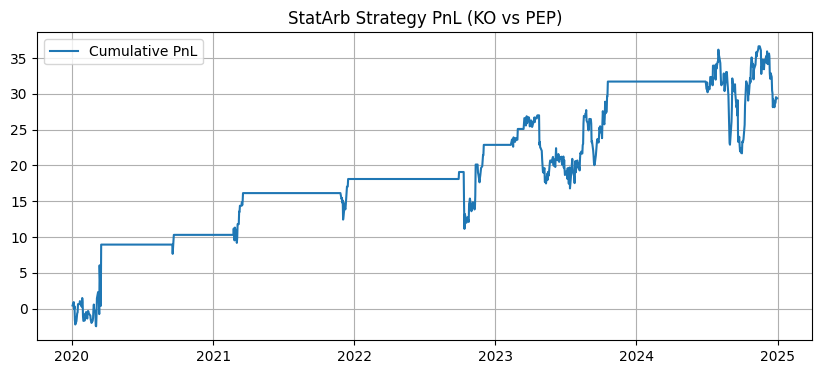

In [7]:
returns = spread.diff()
positions['pnl'] = positions['spread_pos'].shift(1) * returns
positions['cum_pnl'] = positions['pnl'].cumsum()

plt.figure(figsize=(10, 4))
plt.plot(positions['cum_pnl'], label='Cumulative PnL')
plt.title('StatArb Strategy PnL (KO vs PEP)')
plt.grid(True)
plt.legend()
plt.show()


In [8]:
from scipy.stats import skew, kurtosis

def compute_stats(pnl_series):
    daily_pnl = pnl_series.dropna()
    sharpe = np.mean(daily_pnl) / np.std(daily_pnl) * np.sqrt(252)
    max_dd = np.max(np.maximum.accumulate(daily_pnl.cumsum()) - daily_pnl.cumsum())
    return {
        'Total Return': pnl_series.sum(),
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd,
        'Mean Daily PnL': np.mean(daily_pnl),
        'Std Daily PnL': np.std(daily_pnl),
        'Skewness': skew(daily_pnl),
        'Kurtosis': kurtosis(daily_pnl)
    }

stats = compute_stats(positions['pnl'])
pd.DataFrame(stats, index=['KO vs PEP'])


,Total Return,Sharpe Ratio,Max Drawdown,Mean Daily PnL,Std Daily PnL,Skewness,Kurtosis
KO vs PEP,29.378982,0.489851,14.467993,0.023391,0.758024,0.991528,27.868908


In [29]:
# Sector-diverse liquid pairs
pairs = [("GLD", "GDX"), ("SPY", "IVV"), ("XLE", "XOM")]

In [40]:
all_tickers = list(set([t for pair in pairs for t in pair]))
data = yf.download(all_tickers, start="2020-01-01", end="2024-12-31")['Close']
data = data.dropna()


/tmp/ipython-input-40-417438968.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(all_tickers, start="2020-01-01", end="2024-12-31")['Close']
[*********************100%***********************]  6 of 6 completed


In [41]:
def backtest_pair(X, Y, window=100, entry=1.0, exit=0.5):
    pnl = []
    zscores = []
    positions = []

    position = 0  # Current position: 1 (long spread), -1 (short spread), 0 (flat)

    for i in range(window, len(X)):
        X_window = X[i - window:i]
        Y_window = Y[i - window:i]

        # Estimate hedge ratio from rolling OLS
        model = OLS(Y_window, add_constant(X_window)).fit()
        hedge = model.params[1]

        # Compute spread and z-score
        spread = Y - hedge * X
        spread_window = spread[i - window:i]
        current_spread = spread[i]
        mean = spread_window.mean()
        std = spread_window.std()
        z = (current_spread - mean) / std

        # Trading rule
        if z > entry:
            position = -1  # Short spread
        elif z < -entry:
            position = 1   # Long spread
        elif abs(z) < exit:
            position = 0   # Close position

        # PnL from spread returns
        spread_return = spread[i] - spread[i - 1]
        pnl.append(position * spread_return)
        zscores.append(z)
        positions.append(position)

    # Build aligned time series
    index = X.index[window:]
    return pd.Series(pnl, index=index), pd.Series(zscores, index=index)


/tmp/ipython-input-35-2018408121.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge = model.params[1]
/tmp/ipython-input-35-2018408121.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_spread = spread[i]
/tmp/ipython-input-35-2018408121.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread_return = spread[i] - spread[i - 1]
/tmp/ipython-input-35-2018408121.py:14: FutureWarning: Series.__getitem__ treating ke

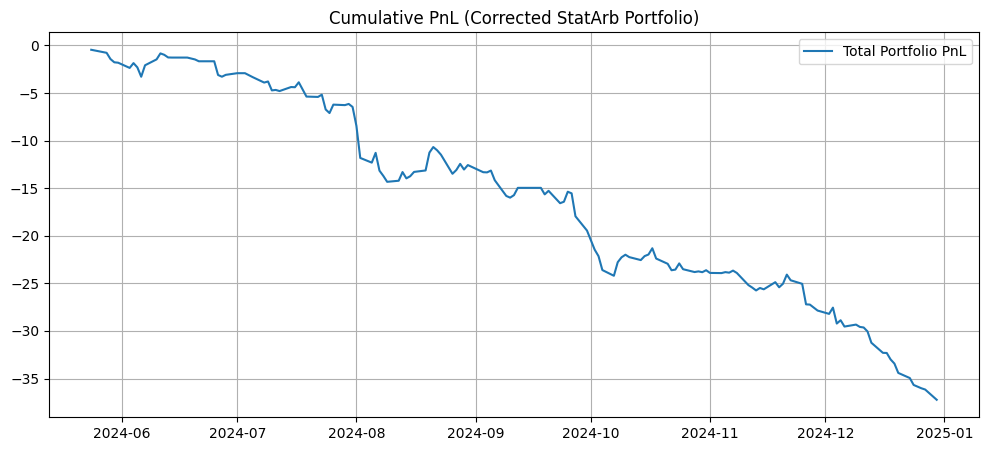

In [36]:
results = []
for t1, t2 in pairs:
    X = data[t1]
    Y = data[t2]
    pair_pnl, zscore = backtest_pair(X, Y)
    results.append(pair_pnl.rename(f"{t1}-{t2}"))

# Combine into portfolio
pnl_df = pd.concat(results, axis=1)
pnl_df['Total'] = pnl_df.sum(axis=1)

# Plot cumulative PnL
plt.figure(figsize=(12, 5))
plt.plot(pnl_df['Total'].cumsum(), label="Total Portfolio PnL")
plt.title("Cumulative PnL (Corrected StatArb Portfolio)")
plt.grid(True)
plt.legend()
plt.show()


In [39]:
def portfolio_stats(pnl_series):
    daily = pnl_series.dropna()
    sharpe = np.mean(daily) / np.std(daily) * np.sqrt(252)
    max_dd = np.max(np.maximum.accumulate(daily.cumsum()) - daily.cumsum())
    return {
        'Total Return': daily.sum(),
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

portfolio_stats(pnl_df['Total'])


{'Total Return': np.float64(-37.234989214608525),
 'Sharpe Ratio': np.float64(-5.256975158910632),
 'Max Drawdown': 36.77543847593696}